<a href="https://colab.research.google.com/github/bomiiisong/DeepLearning-with-Python/blob/master/NLP/Word2Vec_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Korean Word2Vec

> ## Naver 영화 리뷰 데이터

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Ⅰ. Install & Import Packages

* Install Konlpy

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.5MB/s 
     |████████████████████████████████| 92kB 8.2MB/s 
     |████████████████████████████████| 460kB 35.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


* Import Packasges

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

## Ⅱ. Data Preprocessing

> ### 1) naverRatings.zip

* Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/naverRatings.zip

-rw------- 1 root root 7903524 Mar 31 02:17 '/content/drive/My Drive/Colab Notebooks/datasets/naverRatings.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/naverRatings.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/naverRatings.zip
  inflating: naverRatings.txt        


In [ ]:
!ls -l naverRatings.txt

-rw-r--r-- 1 root root 19515078 May  4  2020 naverRatings.txt


> ### 2) Data Load

* Label : '1'(Positive) / '0'(Negative)

In [ ]:
train_data = pd.read_table('naverRatings.txt')
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
print(len(train_data))

200000


> ### 3. Data cleaning

* NULL 값 존재 확인

In [ ]:
print(train_data.isnull().values.any())

True


* NULL 값 존재 행 제거 후 재확인

In [ ]:
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

False


* NULL 값 제거 후 데이터 개수

In [ ]:
print(len(train_data))

199992


> ### 4) 정규표현식을 통한 한글 외 문자 제거

In [ ]:
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '') # ^ 의미 : 입력한 표현 제외하고 나머지 선택

* 처리 결과 확인

In [ ]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [ ]:
train_data['document'].shape

(199992,)

> ### 5) 불용어(StopWord) 지정

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

> ### 6) Okt()를 활용한 토큰화 및 불용어 제거
* 약 10분 소요

In [ ]:
%%time

from konlpy.tag import Okt

okt = Okt()
tokenized_data = []

for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    tokenized_data.append(temp_X)

CPU times: user 13min, sys: 3.64 s, total: 13min 3s
Wall time: 12min 32s


In [ ]:
len(tokenized_data)

199992

## Ⅲ. 리뷰 데이터 분포 시각화

> ### 1) 리뷰 길이 확인

In [ ]:
print('리뷰의 최대 길이 : ', max(len(i) for i in tokenized_data))
print('리뷰의 평균 길이 : ', sum(map(len, tokenized_data)) / len(tokenized_data))

리뷰의 최대 길이 :  72
리뷰의 평균 길이 :  10.716703668146726


> ### 2) 리뷰 길이 시각화

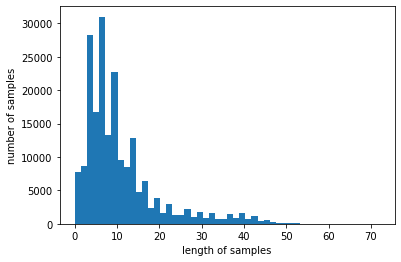

In [ ]:
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## Ⅳ. Word2Vec 수행

> ### 1) 임베딩 학습

* Vector dimension : 100
* window size : 5
* size : 워드 벡터 특징 값 (임베딩 된 벡터의 차원)
* window : context window 크기
* min_count : 단어 최소 빈도 수 제한(빈도 적은 단어는 학습 X)
* workers : 학습을 위한 프로세스 수
* sg
    * sg = 0 : CBOW
    * sg = 1 : Skip-gram

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=tokenized_data, size=100, window=5, min_count=5, workers=4, sg=1)

> ### 2) 학습된 임베딩 매트릭스 크기 확인

In [ ]:
model.wv.vectors.shape

(16477, 100)

## Ⅴ. 임베딩 결과 테스트

In [ ]:
model.wv.most_similar('코미디')

[('블랙코미디', 0.8183404207229614),
 ('코메디', 0.8048497438430786),
 ('코믹', 0.7878007888793945),
 ('로맨틱', 0.7705299854278564),
 ('로멘틱', 0.7537550330162048),
 ('로맨틱코미디', 0.7509869933128357),
 ('개그', 0.7381646633148193),
 ('메다', 0.7318242788314819),
 ('스릴러', 0.7255707383155823),
 ('로멘', 0.7219288349151611)]

## Ⅵ. 사전 훈련된 Word2Vec

> ### 1) Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/ko_w2v.zip

-rw------- 1 root root 80596565 Mar 31 02:17 '/content/drive/My Drive/Colab Notebooks/datasets/ko_w2v.zip'


> ### 2) Unzip 'ko_w2v.zip'

In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/ko_w2v.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/ko_w2v.zip
  inflating: ko.bin                  
  inflating: ko.tsv                  


> ### 3) Word2Vec 가져오기

In [ ]:
import gensim

In [ ]:
model = gensim.models.Word2Vec.load('ko.bin')

> ### 4) Word2Vec Test

In [ ]:
model.wv.most_similar('여행')

[('항해', 0.6019408702850342),
 ('탐험', 0.5845088362693787),
 ('여행자', 0.5578233599662781),
 ('체류', 0.5551776885986328),
 ('방문', 0.5392764806747437),
 ('여정', 0.5236952900886536),
 ('순방', 0.5188454985618591),
 ('유람', 0.5148690938949585),
 ('돌아다니', 0.5122348070144653),
 ('하이킹', 0.48751991987228394)]